In [ ]:
#Goal- bring in data and create final versions of figures for essential workers in DC
#Also, create data sets as needed for Choropleths

In [148]:
import pandas as pd
import requests
import numpy as np
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
colorlist = ['#000000','#0C6B0C',  "#082B84", "#3F1D63",'#086984',"#C91414", "#FF6D00",'#D9B81F' ] 

figure_size =  (15,8)
barfigsize = (11,6)
barwidth = 0.6
font_size_var = 1.8
label_size= 20
axis_pad = 15



def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        
    

In [2]:
#bringing in the csv with DC census block groups with telework

#Mapping DC wards to census tracts:
tract_data_df = pd.read_csv("DC_tracts_to_wards.csv")

#Percent workers who can work from home in DC:
telework = pd.read_csv("dc_telework_estimates.csv")
telework.rename(columns = {'GEO_ID': 'GEOID'}, inplace = True)
telework.head()

#Socioeconimic data set, by ward, of DC:
soc_health_df = pd.read_csv("demographic_datasets/dc_census_tracts_health_2017_social_2018_sex_5yr_ACS_2018.csv")
soc_health_df.rename(columns = {'Unnamed: 0':'GEOID'}, inplace = True)
soc_health_df.head()


#Cases and deaths for DC, by day/ward (from notebook DC Case data):
dc_data = pd.read_csv("cases_by_ward_timeline011521.csv")
dc_data.Date.max()

ward_pop = pd.read_csv("/Users/alainacase/Documents/DC Policy analysis/Data/Ward_population.csv",
                      dtype={'Population': int})

dc_all_cases = dc_data.merge(ward_pop, on = 'Ward')
dc_all_cases['Total cases per 100k'] =(dc_all_cases['Cases']/dc_all_cases['Population'])*100000
dc_all_cases['Total deaths per 100k'] =(dc_all_cases['Deaths']/dc_all_cases['Population'])*100000 
dc_all_cases.head()

#Bring in SafeGraph data and compare to Telework:

df_stayhome = pd.read_csv("dc_socia_distancingdata_01062021.csv")
df_stayhome['date_range_start'] = pd.to_datetime(df_stayhome['date_range_start'], format = '%Y-%m-%d')
df_stayhome['date_range_end'] = pd.to_datetime(df_stayhome['date_range_end'], format = '%Y-%m-%d')


df_stayhome.head()

,WARD,GEOID,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,bucketed_distance_traveled,median_dwell_at_bucketed_distance_traveled,completely_home_device_count,...,candidate_device_count,bucketed_away_from_home_time,median_percentage_time_home,bucketed_percentage_time_home,mean_home_dwell_time,mean_non_home_dwell_time,mean_distance_traveled_from_home,Week_Number,origin_census_tract,percent_home_device
0,8,11001007409,110010074093,2020-01-14,2020-01-15,58,6719.0,"{""16001-50000"":4,""0"":19,"">50000"":3,""2001-8000""...","{""16001-50000"":99,"">50000"":32,""<1000"":132,""200...",18,...,127,"{""21-45"":1,""481-540"":6,""541-600"":3,""46-60"":2,""...",72,"{""26-50"":5,""51-75"":12,""0-25"":12,"">100"":1,""76-1...",NaN,NaN,NaN,3,11001007409,0.310345
1,8,11001007409,110010074092,2020-01-14,2020-01-15,59,4475.0,"{""16001-50000"":5,""0"":16,"">50000"":2,""2001-8000""...","{""16001-50000"":391,"">50000"":625,""<1000"":19,""20...",17,...,164,"{""21-45"":3,""481-540"":1,""541-600"":3,""46-60"":1,""...",86,"{""26-50"":2,""51-75"":5,""0-25"":16,"">100"":2,""76-10...",NaN,NaN,NaN,3,11001007409,0.288136
2,8,11001007409,110010074091,2020-01-14,2020-01-15,69,3834.0,"{""16001-50000"":2,""0"":26,"">50000"":2,""2001-8000""...","{""16001-50000"":40,"">50000"":152,""<1000"":226,""20...",23,...,151,"{""481-540"":1,""541-600"":1,""46-60"":1,""721-840"":1...",78,"{""26-50"":5,""51-75"":11,""0-25"":16,"">100"":1,""76-1...",NaN,NaN,NaN,3,11001007409,0.333333
3,8,11001007409,110010074093,2020-01-18,2020-01-19,56,6614.0,"{""16001-50000"":1,""0"":21,"">50000"":2,""2001-8000""...","{""16001-50000"":14,"">50000"":252,""<1000"":27,""200...",22,...,127,"{""21-45"":3,""481-540"":3,""46-60"":1,""301-360"":4,""...",90,"{""0-25"":10,""76-100"":36,""51-75"":7,""26-50"":6}",NaN,NaN,NaN,3,11001007409,0.392857
4,8,11001007409,110010074092,2020-01-18,2020-01-19,66,4380.0,"{""16001-50000"":1,""0"":21,"">50000"":1,""2001-8000""...","{""16001-50000"":31,"">50000"":39,""<1000"":22,""2001...",22,...,164,"{""21-45"":4,""541-600"":2,""46-60"":1,""721-840"":3,""...",86,"{""26-50"":2,""51-75"":4,""0-25"":20,"">100"":3,""76-10...",NaN,NaN,NaN,3,11001007409,0.333333


In [3]:
#************************************
#Get pre-covid comparison numbers:
#************************************
agg_sf = {'completely_home_device_count':'median', 
          'device_count':'median',
         'distance_traveled_from_home': 'median',
         'candidate_device_count':'median',
         'median_home_dwell_time': 'median',
         'part_time_work_behavior_devices':'median',
         'full_time_work_behavior_devices':'median',
        'median_percentage_time_home':'median',
         'percent_home_device': 'mean'}


agg_sf_ward = {'completely_home_device_count':'sum', 
          'device_count':'sum',
         'distance_traveled_from_home': 'median',
         'candidate_device_count':'sum',
         'median_home_dwell_time': 'median',
         'part_time_work_behavior_devices':'sum',
         'full_time_work_behavior_devices':'sum',
        'median_percentage_time_home':'median'}


pre_covid = df_stayhome[ (df_stayhome['date_range_start'] >= '2020-01-01') &
                      (df_stayhome['date_range_start'] <= '2020-02-20')]

#aggregating by ward and geoid:
#pre_covid = pre_covid.groupby(['WARD', 'GEOID']).agg(agg_sf).reset_index()
#Merge back onto the original data to get % changes:
#df_stayhome_all = df_stayhome.merge(pre_covid, on = ['WARD', 'GEOID'], suffixes=('', '_base'))


#Aggregate by just ward:
pre_covid = pre_covid.groupby(['WARD']).agg(agg_sf).reset_index()
#Merge back onto the original data to get % changes:
df_stayhome_ward = df_stayhome.groupby(['WARD','date_range_start']).agg(agg_sf).reset_index()
df_stayhome_ward['percent_home_device'] = round(df_stayhome_ward['completely_home_device_count']/df_stayhome_ward['device_count']*100,2)
df_stayhome_all = df_stayhome_ward.merge(pre_covid, on = ['WARD'], suffixes=('', '_base'))
#Note- for some reason there are a lot of NA's in the mean home time, but not median 89114 for mean, 0 for median

#getting the raw change and % change:
col_list =  ['completely_home_device_count_base', 'device_count_base',
       'distance_traveled_from_home_base', 'candidate_device_count_base',
       'median_home_dwell_time_base', 'part_time_work_behavior_devices_base',
       'full_time_work_behavior_devices_base',
       'median_percentage_time_home_base', 'percent_home_device_base']

for col_name in col_list:
    compare_name = col_name.replace("_base", "")  
    new_name = compare_name + '_raw_difference'
    new_name2 = compare_name + '_percent_change'
    #get the raw difference:
    df_stayhome_all[new_name]= df_stayhome_all[compare_name]- df_stayhome_all[col_name]
    #get the percent difference:
    df_stayhome_all[new_name2] = round((df_stayhome_all[new_name] / df_stayhome_all[col_name]) * 100,1)
 

#
df_stayhome_all.head()


,WARD,date_range_start,completely_home_device_count,device_count,distance_traveled_from_home,candidate_device_count,median_home_dwell_time,part_time_work_behavior_devices,full_time_work_behavior_devices,median_percentage_time_home,...,median_home_dwell_time_raw_difference,median_home_dwell_time_percent_change,part_time_work_behavior_devices_raw_difference,part_time_work_behavior_devices_percent_change,full_time_work_behavior_devices_raw_difference,full_time_work_behavior_devices_percent_change,median_percentage_time_home_raw_difference,median_percentage_time_home_percent_change,percent_home_device_raw_difference,percent_home_device_percent_change
0,1,2020-01-01,16.0,55.0,4680.0,122.0,377.0,1.0,1.0,89.0,...,-110.0,-22.6,-2.0,-66.7,-1.0,-50.0,14.0,18.7,28.799074,9899.1
1,1,2020-01-02,15.0,52.0,3822.0,122.0,439.0,4.0,3.0,74.0,...,-48.0,-9.9,1.0,33.3,1.0,50.0,-1.0,-1.3,28.559074,9816.6
2,1,2020-01-03,18.0,55.0,3595.0,122.0,407.0,4.0,3.0,76.0,...,-80.0,-16.4,1.0,33.3,1.0,50.0,1.0,1.3,32.439074,11150.3
3,1,2020-01-04,20.0,54.0,3868.0,122.0,531.0,2.0,1.0,92.0,...,44.0,9.0,-1.0,-33.3,-1.0,-50.0,17.0,22.7,36.749074,12631.8
4,1,2020-01-05,20.0,56.0,3239.0,122.0,558.0,2.0,1.0,94.0,...,71.0,14.6,-1.0,-33.3,-1.0,-50.0,19.0,25.3,35.419074,12174.6


In [126]:
#Get the data for all of DC, on a daily basis:

agg_sf_week = {'completely_home_device_count':'sum', 
          'device_count':'sum', 
               'full_time_work_behavior_devices':'sum',
          'percent_home_device':'mean',
          'median_home_dwell_time':'median',
              'completely_home_device_count_raw_difference': 'mean',
             'completely_home_device_count_percent_change':'mean',
              'full_time_work_behavior_devices_percent_change': 'mean',
              }

daily_dc = df_stayhome_all.groupby(['date_range_start']).agg(agg_sf_week).reset_index()
daily_dc['Percent of stay at home devices'] = round(daily_dc['percent_home_device'],1)
daily_dc['Percent of stay at home devices moving'] = round(daily_dc['Percent of stay at home devices'].rolling(window=7).mean(),2)
daily_dc['Full time work devices percent change moving'] = round(daily_dc['full_time_work_behavior_devices_percent_change'].rolling(window=7).mean(),2)
daily_dc['Full time work devices count'] = round(daily_dc['full_time_work_behavior_devices'].rolling(window=7).mean(),2)

daily_dc['Full time work devices percent'] = (daily_dc['full_time_work_behavior_devices']/daily_dc['device_count'])*100

daily_dc.rename(columns = {'date_range_start': 'Date'}, inplace = True)
daily_dc['Date'] = pd.to_datetime(daily_dc['Date'], format = '%Y-%m-%d')
daily_dc.head()

,Date,completely_home_device_count,device_count,full_time_work_behavior_devices,percent_home_device,median_home_dwell_time,completely_home_device_count_raw_difference,completely_home_device_count_percent_change,full_time_work_behavior_devices_percent_change,Percent of stay at home devices,Percent of stay at home devices moving,Full time work devices percent change moving,Full time work devices count,Full time work devices percent
0,2020-01-01,130.0,409.5,8.0,31.09125,484.25,3.0000,21.8375,-50.000,31.1,NaN,NaN,NaN,1.953602
1,2020-01-02,118.5,408.0,18.5,28.41375,489.25,1.5625,11.4000,15.625,28.4,NaN,NaN,NaN,4.534314
2,2020-01-03,121.0,412.0,21.0,28.88375,481.75,1.8750,16.2500,31.250,28.9,NaN,NaN,NaN,5.097087
3,2020-01-04,144.5,411.5,8.0,34.70000,591.75,4.8125,38.4500,-50.000,34.7,NaN,NaN,NaN,1.944107
4,2020-01-05,152.5,418.5,8.0,35.94000,635.00,5.8125,46.3000,-50.000,35.9,NaN,NaN,NaN,1.911589


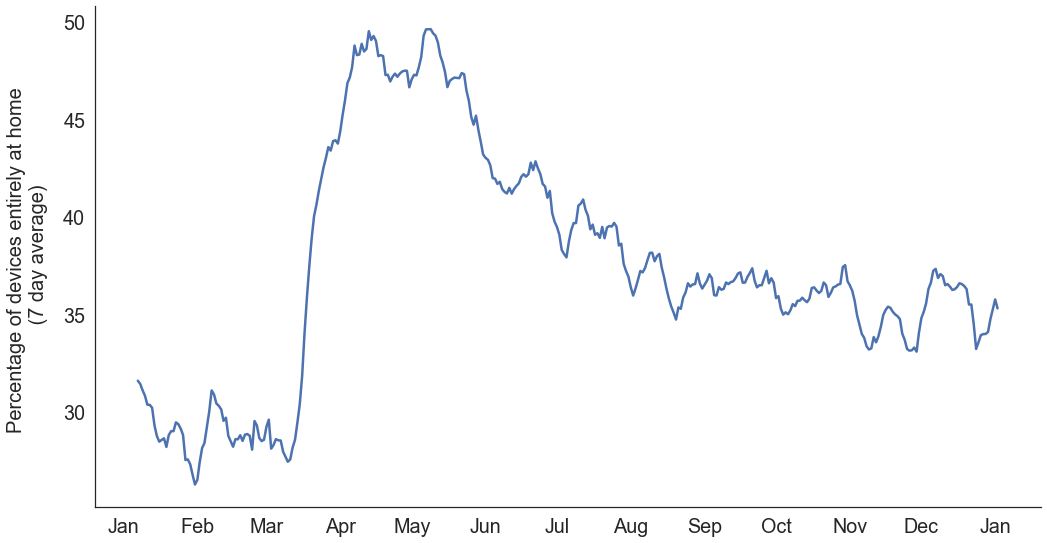

In [127]:
#*********************************************************************
#Figure: Percent of devices that stayed at home, for all of DC:
#*********************************************************************
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import calendar
import matplotlib.ticker as ticker


title = "SafeGraph mobility data for DC: Average percent of stay at home devices during COVID-19"
sns.set(font_scale=font_size_var,rc={"lines.linewidth": 2.5},)
sns.set_style("white")


fig, ax = plt.subplots(figsize=(figure_size))


sns.lineplot(x="Date", y="Percent of stay at home devices moving",
              palette = colorlist,
             data=daily_dc)
#plt.title(title)
plt.xlabel("")
plt.ylabel("Percentage of devices entirely at home \n (7 day average)", 
           size = label_size, labelpad = axis_pad )

#ax.tick_params(axis = 'x', which = 'major', length = 10)
#ax.tick_params(axis = 'x', which = 'minor', length = 5)


ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b"))

sns.despine()
plt.tight_layout()

#plt.xticks(rotation = 'vertical')
plt.savefig(title + ".png", dpi=500, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')





In [131]:
3

36.00433333333333

In [13]:
#*************************************************************************************************
#Figure 1 Data: What percent of the population, in each DC ward, can transition to working from home:
#************************************************************************************************
df_telework = telework.merge(tract_data_df, on ='GEOID')
ess = {'total_workers': 'sum',
       'teleworker_estimate':'sum',
       'telework_score':'mean'
      }
ward_wfh = df_telework.groupby(['WARD']).agg(ess).reset_index()
ward_wfh['Estimate of people who can work from home (%)']  = round(ward_wfh['telework_score']*100)
ward_wfh.rename(columns = {'WARD': 'DC ward number'}, inplace = True)
ward_wfh.head()

,DC ward number,total_workers,teleworker_estimate,telework_score,Estimate of people who can work from home (%)
0,1,81333.0,44024.444418,0.541500,54.0
1,2,85892.0,50302.381891,0.583430,58.0
2,3,78419.0,43652.598045,0.551055,55.0
3,4,74177.0,34529.012584,0.459276,46.0
4,5,83904.0,39646.043507,0.465110,47.0


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


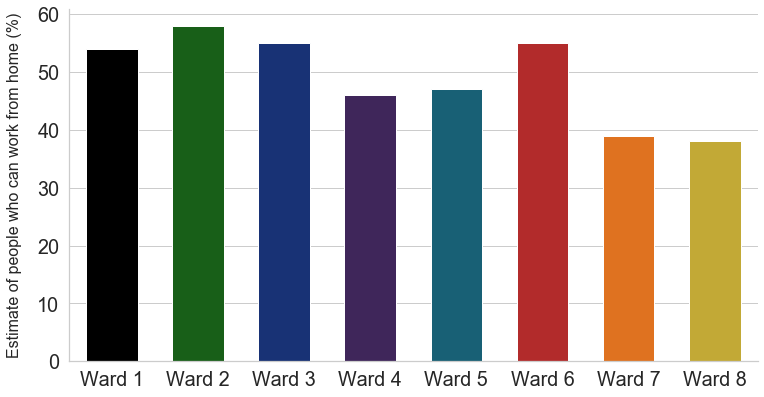

In [149]:
#***************************
#Figure 1 plot
#***************************



title = "Estimate of population that can transition to working from home in DC"
fig, ax = plt.subplots(figsize=barfigsize)

sns.set(font_scale=1.6)
sns.set_style("white")
sns.despine()

ward_wfh['name'] = np.where(ward_wfh['DC ward number'] == 1, 'Ward 1',
                               np.where(ward_wfh['DC ward number'] == 2, 'Ward 2',
                                       np.where(ward_wfh['DC ward number']== 3, 'Ward 3',
                                               np.where(ward_wfh['DC ward number'] == 4, 'Ward 4',
                                                       np.where(ward_wfh['DC ward number']== 5, 'Ward 5',
                                                               np.where(ward_wfh['DC ward number'] == 6, 'Ward 6',
                                                                       np.where(ward_wfh['DC ward number'] == 7, 'Ward 7',
                                                                               np.where(ward_wfh['DC ward number'] == 8, 'Ward 8', 'NULL'))))))))


sns.barplot(x="name", 
            y="Estimate of people who can work from home (%)",
            data=ward_wfh, 
            palette = colorlist)

change_width(ax, barwidth)

#plt.title(title)
plt.xlabel("")
plt.ylabel("Estimate of people who can work from home (%)",
           size = 16,
          labelpad = axis_pad )
plt.tight_layout()

plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

In [146]:
#*************************************************************************************************
#Figure 2 Data: How do socioeconomic factors relate to the ability to work from home
#************************************************************************************************
essential_data = soc_health_df.merge(df_telework, on = 'GEOID')
essential_data.rename(columns = {'WARD': 'Ward'},inplace = True)

essential_data['Percent work from home'] = round(essential_data['telework_score']*100,1)
essential_data.rename(columns = {'Ward': 'DC Ward'}, inplace = True)
essential_data.head()

,GEOID,copd,current_asthma,current_smoking,obesity,coronary_heart_disease,cancer_(except_skin),chronic_kidney_disease,diabetes,health_insurance,...,Construction and extraction occupations_telework_weighted,"Installation, maintenance, and repair occupations_telework_weighted",Production occupations_telework_weighted,teleworker_estimate,total_workers,telework_score,Unnamed: 0,DC Ward,geometry,Percent work from home
0,11001000701,4.1,8.1,9.5,18.3,4.5,7.4,2.5,6.2,4.4,...,0.000000,0.000000,0.765766,1858.802370,3406.0,0.545744,6,3,"POLYGON ((-77.0580817725277 38.95675941165724,...",54.6
1,11001002802,4.6,9.5,18.7,24.6,3.6,3.7,2.4,7.6,14.2,...,5.983607,0.000000,0.000000,1425.862712,3309.0,0.430904,4,1,POLYGON ((-77.03523283997743 38.93743450516117...,43.1
2,11001005002,3.3,8.3,14.4,22.2,2.6,3.3,1.9,5.3,8.4,...,0.639344,0.240741,0.540541,2342.377156,4017.0,0.583116,3,2,POLYGON ((-77.04945527480312 38.91999484158998...,58.3
3,11001008410,3.2,9.2,12.4,23.4,2.9,4.4,2.1,6.7,5.9,...,0.000000,0.129630,0.000000,585.110132,1063.0,0.550433,1,6,"POLYGON ((-77.0178960689709 38.91409546158741,...",55.0
4,11001008410,3.2,9.2,12.4,23.4,2.9,4.4,2.1,6.7,5.9,...,0.000000,0.129630,0.000000,585.110132,1063.0,0.550433,5,5,"POLYGON ((-76.99143503979558 38.957303536057, ...",55.0


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


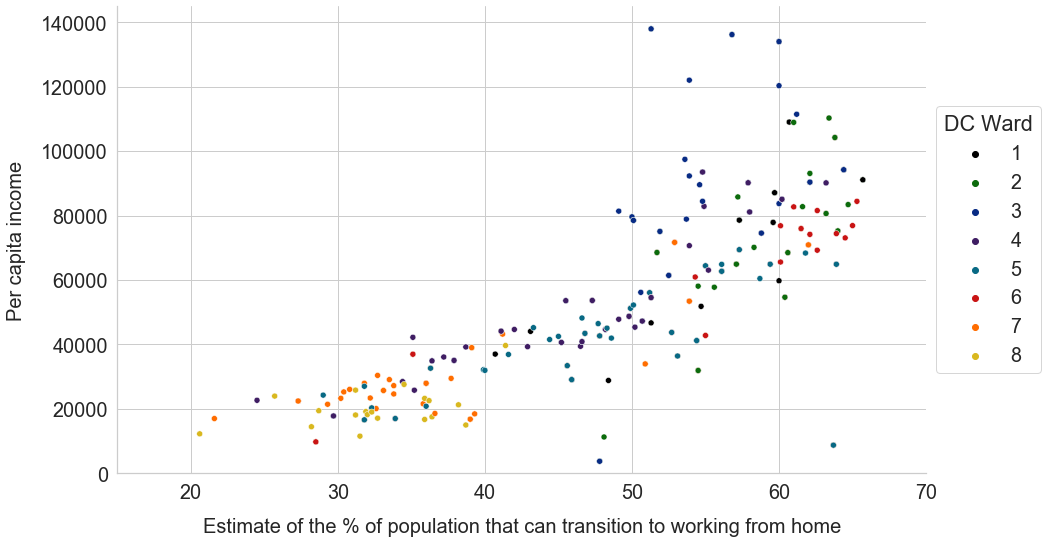

In [161]:
#***************************************************************
#Figure 2 Plot: Income and ability to work from home
#***************************************************************

fig, ax = plt.subplots(figsize=figure_size)
title = "Income and ability to work from home in DC"

sns.set(font_scale=font_size_var)
sns.set_style("whitegrid")
sns.despine()
g = sns.scatterplot(data=essential_data, x="Percent work from home", y="per_capita_income",
                hue="DC Ward",  legend = "full",
                palette = colorlist)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.legend_.set_title('DC Ward')
plt.xlabel("Estimate of the % of population that can transition to working from home", 
           size = label_size, labelpad = axis_pad )
plt.ylabel("Per capita income", size = label_size, labelpad = axis_pad )
#plt.title(title)
plt.xlim(15,70)
plt.ylim(0,None)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

In [134]:

corr, pval = pearsonr(essential_data["Percent work from home"], essential_data['per_capita_income'])
print (corr, pval)

0.7062616884145074 5.407416750633599e-43


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


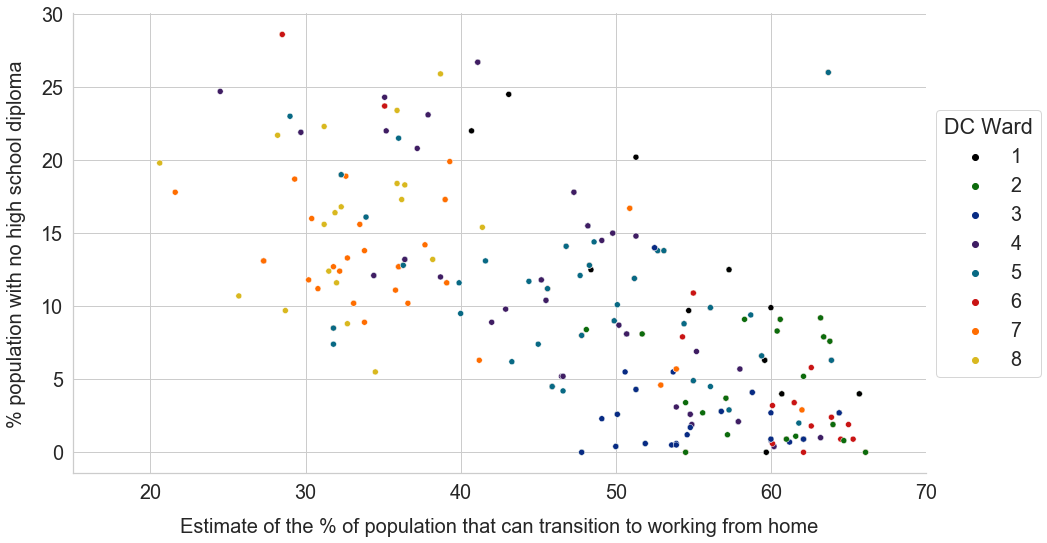

In [151]:
#***************************************************************
#Figure 3 Plot: High school degree and ability to work from home
#***************************************************************

title = "High school diploma and ability to work from home in DC"
fig, ax = plt.subplots(figsize=figure_size)
sns.set(font_scale=font_size_var)
sns.set_style("whitegrid")
sns.despine()
g = sns.scatterplot(data=essential_data, x="Percent work from home", y="no_high_school_diploma",
                hue="DC Ward",  legend = "full",palette = colorlist)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.legend_.set_title('DC Ward')

plt.ylabel("% population with no high school diploma", 
           size = label_size, labelpad = axis_pad )
plt.xlabel("Estimate of the % of population that can transition to working from home", 
           size = label_size, labelpad = axis_pad )
plt.xlim(15,70)
#plt.title(title)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    


#plt.ylim(0,40)

In [135]:
corr, pval = pearsonr(essential_data["Percent work from home"], essential_data['no_high_school_diploma'])
print (corr, pval)

-0.6518746540108492 8.852069427588231e-35


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


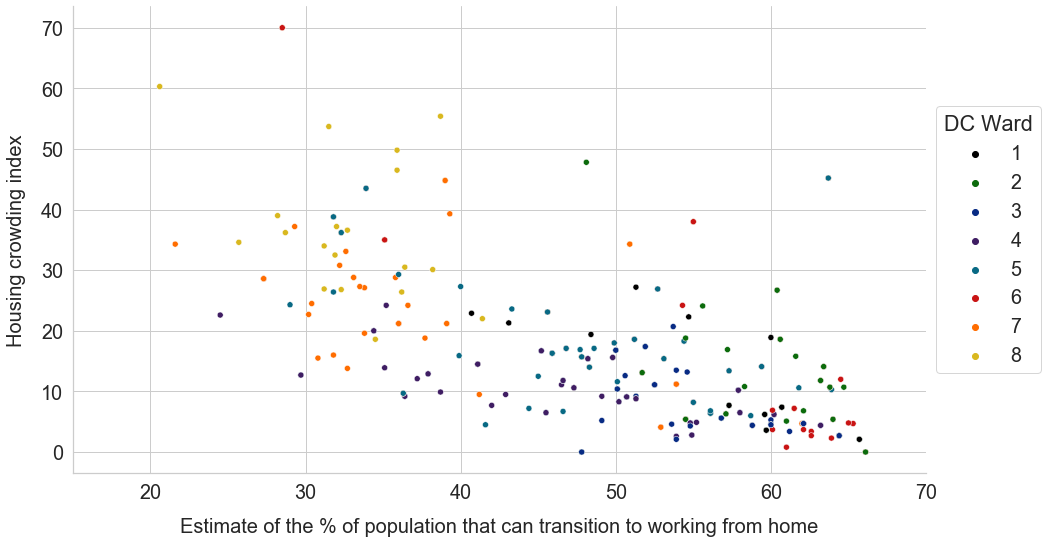

In [152]:
#***************************************************************
#Figure 4 Plot: Housing crowded index and ability to work from home
#***************************************************************

title = "Housing crowding index and ability to work from home in DC"
fig, ax = plt.subplots(figsize=figure_size)
sns.set(font_scale=font_size_var)
sns.set_style("whitegrid")
sns.despine()
g = sns.scatterplot(data=essential_data, x="Percent work from home", y="housing_unit_crowding",
                hue="DC Ward",  legend = "full",palette = colorlist)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.legend_.set_title('DC Ward')
plt.ylabel("Housing crowding index", size = label_size, labelpad=axis_pad)
plt.xlabel("Estimate of the % of population that can transition to working from home", size = label_size,
          labelpad=axis_pad)

plt.xlim(15,70)
#plt.title(title)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    



#plt.ylim(0,40)

/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


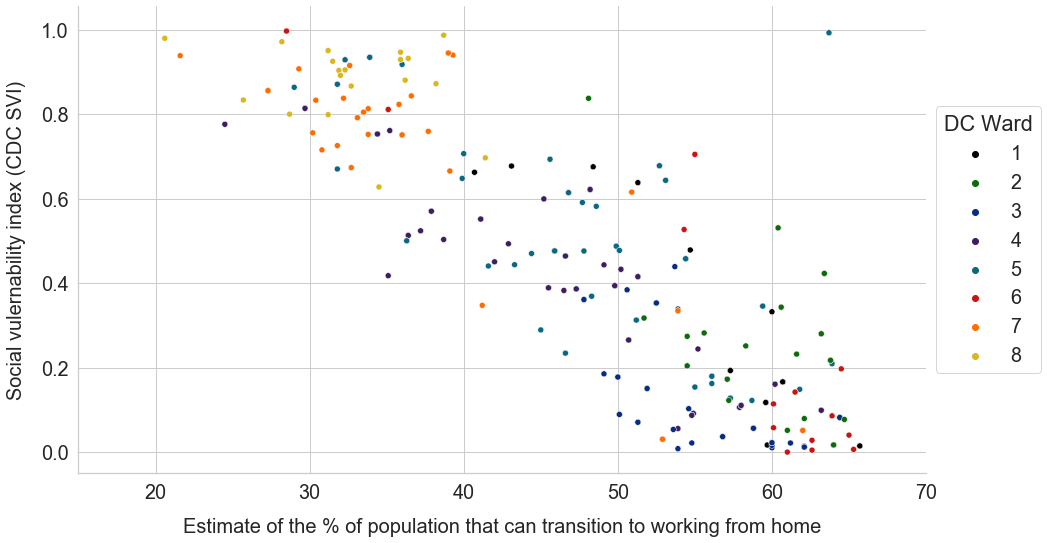

In [162]:
#***************************************************************
#Figure 5 Plot: Income and ability to work from home
#***************************************************************



essential_data['socioeconomic_vulnerability_index'] = np.where(essential_data['socioeconomic_vulnerability_index']== -999.0,
                                                               np.nan, essential_data['socioeconomic_vulnerability_index'])

title = "Socioeconomic vulernability index and the ability to work from home in DC"
fig, ax = plt.subplots(figsize=figure_size)
sns.set(font_scale=font_size_var)
sns.set_style("whitegrid")
sns.despine()
g = sns.scatterplot(data=essential_data, x="Percent work from home", y="socioeconomic_vulnerability_index",
                hue="DC Ward",  legend = "full", palette = colorlist)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.legend_.set_title('DC Ward')
plt.ylabel("Social vulernability index (CDC SVI)", 
           size =label_size, labelpad = axis_pad )
plt.xlabel("Estimate of the % of population that can transition to working from home",
           size = label_size, labelpad = axis_pad )
plt.xlim(15,70)
plt.ylim(-0.05,None)
#plt.title(title)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    



#plt.xlim(10,70)
#plt.ylim(0,40)

In [139]:
essential_data['socioeconomic_vulnerability_index'].fillna(0,inplace = True)
corr, pval = pearsonr(essential_data["Percent work from home"], essential_data['socioeconomic_vulnerability_index'])
print (corr, pval)
#essential_data['socioeconomic_vulnerability_index'].unique()

-0.8195900847996396 3.10712886164175e-68


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


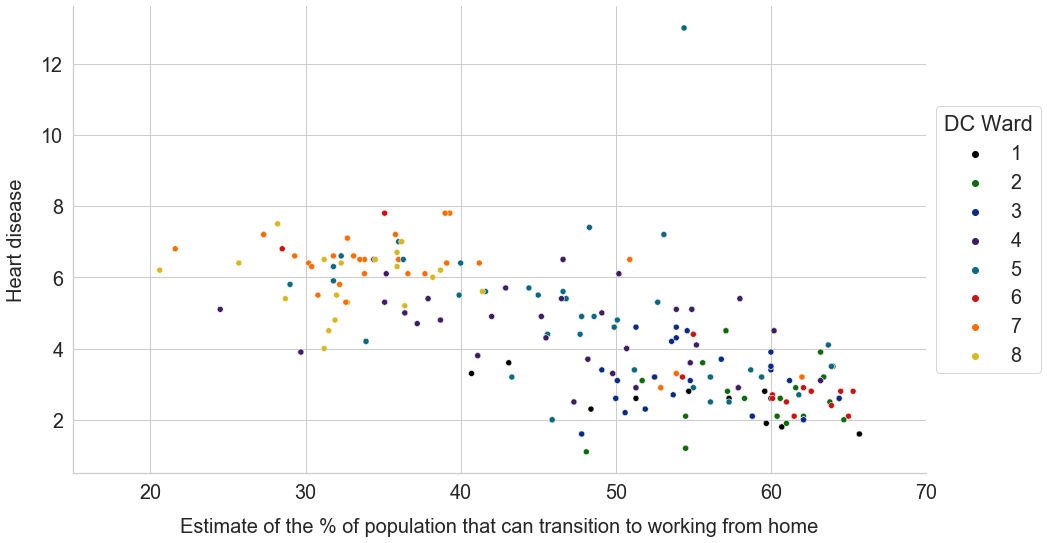

In [154]:
#***************************************************************
#Figure 6 Plot: Coronary heart disease and ability to work from home
#***************************************************************


title= "Heart disease indicator and ability to work from home in DC"
fig, ax = plt.subplots(figsize=figure_size)
sns.set(font_scale=font_size_var)
sns.set_style("whitegrid")
sns.despine()
g = sns.scatterplot(data=essential_data, x="Percent work from home", y="coronary_heart_disease",
                hue="DC Ward",  legend = "full", palette = colorlist)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.legend_.set_title('DC Ward')

plt.ylabel("Heart disease", size =label_size, labelpad = axis_pad  )
plt.xlabel("Estimate of the % of population that can transition to working from home", 
           size = label_size, labelpad = axis_pad)
plt.xlim(15,70)
#plt.title(title)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

#plt.xlim(10,70)
#plt.ylim(0,40)

In [31]:
dc_all_cases.head()

,Date,Ward,Cases,new_Cases,moving_Cases,place_fips,Deaths,new_Deaths,moving_Deaths,Population,cases_per_100k
0,2020-04-19,Ward 1,344.0,14.0,16.07,1,6.0,NaN,NaN,83598,16.746812
1,2020-04-20,Ward 1,355.0,11.0,15.71,1,6.0,0.0,NaN,83598,13.158210
2,2020-04-21,Ward 1,359.0,4.0,14.21,1,6.0,0.0,NaN,83598,4.784803
3,2020-04-22,Ward 1,376.0,17.0,14.57,1,8.0,2.0,NaN,83598,20.335415
4,2020-04-23,Ward 1,403.0,27.0,15.71,1,8.0,0.0,NaN,83598,32.297423


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


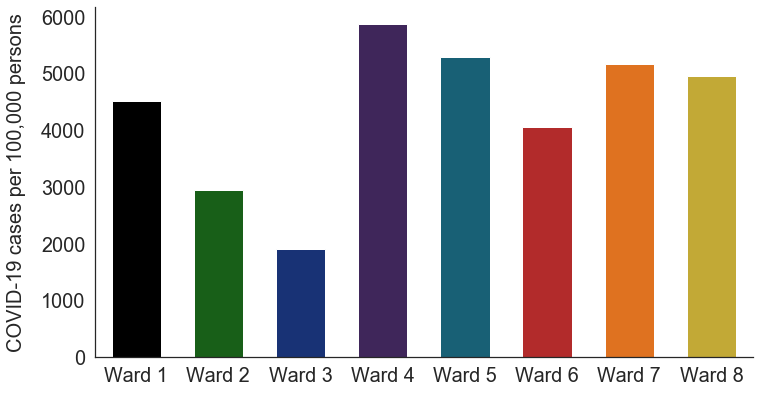

In [156]:
#***************************
#Figure Cases by ward, overall:

#***************************

title = "COVID-19 Cases by Ward as of January 14, 2021"
dc_data_max = dc_all_cases[dc_all_cases['Date'] == '2021-01-03']
dc_data_max = dc_data_max[~dc_data_max['Ward'].isin(['Unknown', 'All DC'])]
fig, ax = plt.subplots(figsize=barfigsize)
sns.set(font_scale=font_size_var)
sns.set_style("white")
sns.despine()
sns.barplot(x="Ward", y="Total cases per 100k",
            data=dc_data_max, palette = colorlist)
plt.ylabel("COVID-19 cases per 100,000 persons", size = label_size, labelpad = axis_pad)
plt.xlabel("")


change_width(ax, barwidth)


#plt.title(title)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

In [41]:
dc_data_max.head()

,Date,Ward,Cases,new_Cases,moving_Cases,place_fips,Deaths,new_Deaths,moving_Deaths,Population,Total cases per 100k,Total deaths per 100k
258,2021-01-03,Ward 1,3775.0,20.0,27.93,1,87.0,0.0,0.29,83598,4515.658269,104.069475
528,2021-01-03,Ward 2,2304.0,1.0,20.29,2,39.0,0.0,0.07,77940,2956.120092,50.038491
798,2021-01-03,Ward 3,1606.0,7.0,14.57,3,41.0,0.0,0.36,84021,1911.426905,48.797324
1068,2021-01-03,Ward 4,4978.0,24.0,33.57,4,121.0,0.0,0.93,84643,5881.171509,142.953345
1338,2021-01-03,Ward 5,4556.0,20.0,34.93,5,134.0,0.0,1.14,86136,5289.309928,155.567939


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


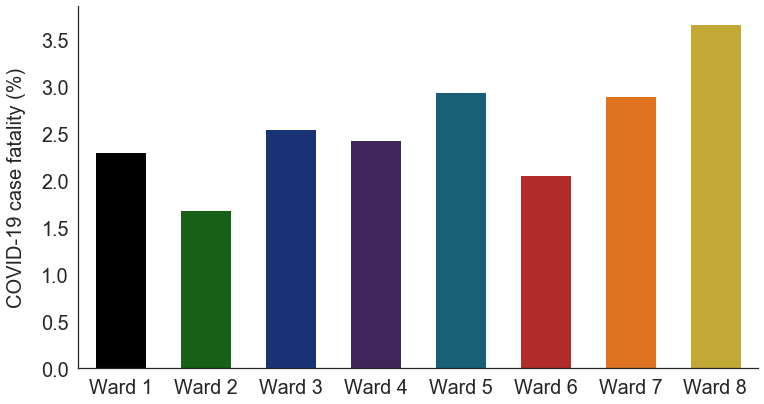

In [157]:
#***************************
#Figure Deaths by ward:
#***************************


title = "COVID-19 case fatality rate as of January 14, 2021"
dc_data_max['Case fatality'] = dc_data_max['Deaths']/dc_data_max['Cases']*100
fig, ax = plt.subplots(figsize=barfigsize)
sns.set(font_scale=1.6)
sns.set_style("white")
sns.despine()
sns.barplot(x="Ward", y="Case fatality",
            data=dc_data_max, palette = colorlist)



change_width(ax, barwidth)

#plt.title(title)
plt.xlabel("")
plt.ylabel("COVID-19 case fatality (%)", size = label_size, labelpad = axis_pad)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


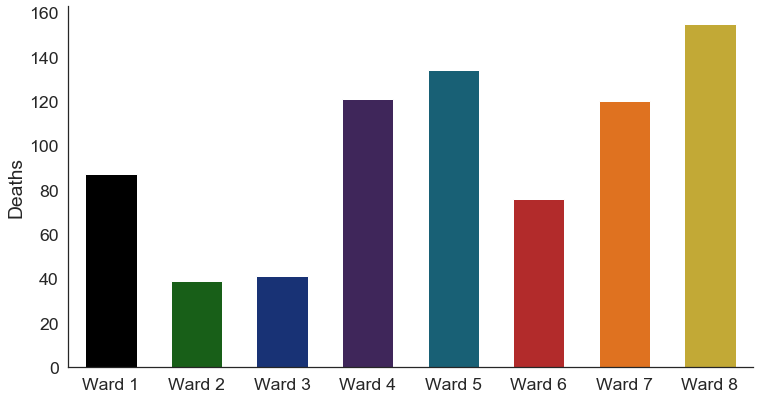

In [158]:
#***************************
#Figure Deaths by ward:
#***************************


title = "COVID-19 Deaths by Ward as of January 14, 2021"

fig, ax = plt.subplots(figsize=barfigsize)
sns.set(font_scale=font_size_var)
sns.set_style("white")
sns.despine()
sns.barplot(x="Ward", y="Deaths",
            data=dc_data_max, palette = colorlist)

change_width(ax, barwidth)
plt.xlabel("")
#plt.title(title)
plt.title("")
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

In [69]:
#*********************************************************************
#Figures for Choropleth of Ward telework scores, cases and deaths:
#*********************************************************************

#Getting daily case and death data, by ward, with telework score:
ward_wfh['DC ward number'] = ward_wfh['DC ward number'].astype(int)
dc_data_ward = dc_data[~dc_data['place_fips'].isin(['Unknown', 'All DC'])] 
dc_data_ward['place_fips']= dc_data_ward['place_fips'].astype(int)
dc_case_death_telework = dc_data_ward.merge(ward_wfh, left_on = 'place_fips', right_on = 'DC ward number')
dc_case_death_telework.rename(columns = {'Date':'date_time'}, inplace = True)
dc_case_death_telework = dc_case_death_telework[['date_time','place_fips',
    'Cases', 'new_Cases', 'moving_Cases', 'place_fips',
       'Deaths', 'new_Deaths', 'moving_Deaths', 'DC ward number',
       'total_workers', 'teleworker_estimate', 'telework_score',
       'Estimate of people who can work from home (%)'
]]
dc_case_death_telework['Estimated % of people who cannot work from home'] = 100- dc_case_death_telework['Estimate of people who can work from home (%)']
dc_case_death_telework.head()
#dc_case_death_telework.to_csv("dc_case_death_telework.csv")
#save this as a csv then use the DC svg map to get dates and telework data
#for spring, summer and fall for cases, and deaths 

/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date_time,place_fips,Cases,new_Cases,moving_Cases,place_fips,Deaths,new_Deaths,moving_Deaths,DC ward number,total_workers,teleworker_estimate,telework_score,Estimate of people who can work from home (%),Estimated % of people who cannot work from home
0,2020-04-19,1,344.0,14.0,16.07,1,6.0,NaN,NaN,1,81333.0,44024.444418,0.5415,54.0,46.0
1,2020-04-20,1,355.0,11.0,15.71,1,6.0,0.0,NaN,1,81333.0,44024.444418,0.5415,54.0,46.0
2,2020-04-21,1,359.0,4.0,14.21,1,6.0,0.0,NaN,1,81333.0,44024.444418,0.5415,54.0,46.0
3,2020-04-22,1,376.0,17.0,14.57,1,8.0,2.0,NaN,1,81333.0,44024.444418,0.5415,54.0,46.0
4,2020-04-23,1,403.0,27.0,15.71,1,8.0,0.0,NaN,1,81333.0,44024.444418,0.5415,54.0,46.0


In [ ]:
dc_case_death_telework.columns

In [70]:
#*********************************************************************
#Bring in SafeGraph data and compare to Telework:
#*********************************************************************
#df_stayhome = pd.read_csv("dc_socia_distancingdata.csv")
sf_df = df_stayhome.merge(df_telework, on = ['GEOID', 'WARD'])

#get baseline data from Feb to use for additional analysis:
prepandemic = sf_df[(sf_df['date_range_start'] > '2020-01-15') & (sf_df['date_range_start'] <= '2020-02-17')]
agg_base = {'percent_home_device':'mean'}
baseline_data = prepandemic.groupby(['WARD', 'GEOID']).agg(agg_base).reset_index()
baseline_data.rename(columns = {'percent_home_device': 'percent_home_baseline'}, inplace = True)
baseline_data.head()



,WARD,GEOID,percent_home_baseline
0,1,11001000501,0.235315
1,1,11001001302,0.236793
2,1,11001002302,0.252329
3,1,11001002400,0.312831
4,1,11001002502,0.321560


In [71]:
#*********************************************************************
#Data Get spring safegraph data and compare to telework scores:
#*********************************************************************

april_wfh = sf_df[(sf_df['date_range_start'] > '2020-04-01') & (sf_df['date_range_start'] <= '2020-05-01')]

agg_sf = {'completely_home_device_count':'median', 
          'device_count':'median', 
          'percent_home_device':'mean',
          'median_home_dwell_time':'median',
         'telework_score':'min'}

spring_data = april_wfh.groupby(['WARD', 'GEOID']).agg(agg_sf).reset_index()
spring_data = spring_data.merge(baseline_data, on = ['WARD', 'GEOID'])
spring_data['spring_increase'] = spring_data['percent_home_device'] -spring_data['percent_home_baseline']
spring_data['spring_pct_increase'] = spring_data['spring_increase']/spring_data['percent_home_baseline'] * 100

spring_data.rename(columns = {'WARD': 'DC Ward'}, inplace = True)

spring_data.head()

,DC Ward,GEOID,completely_home_device_count,device_count,percent_home_device,median_home_dwell_time,telework_score,percent_home_baseline,spring_increase,spring_pct_increase
0,1,11001000501,15.0,42.5,0.390038,115.0,0.621183,0.235315,0.154723,65.751511
1,1,11001001302,36.0,62.0,0.526727,841.0,0.579263,0.236793,0.289934,122.442156
2,1,11001002302,32.5,77.5,0.427334,193.0,0.543772,0.252329,0.175005,69.355635
3,1,11001002400,9.0,20.0,0.453718,781.5,0.506869,0.312831,0.140888,45.036394
4,1,11001002502,20.0,37.0,0.556170,842.5,0.411197,0.321560,0.234610,72.959854


/Users/alainacase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


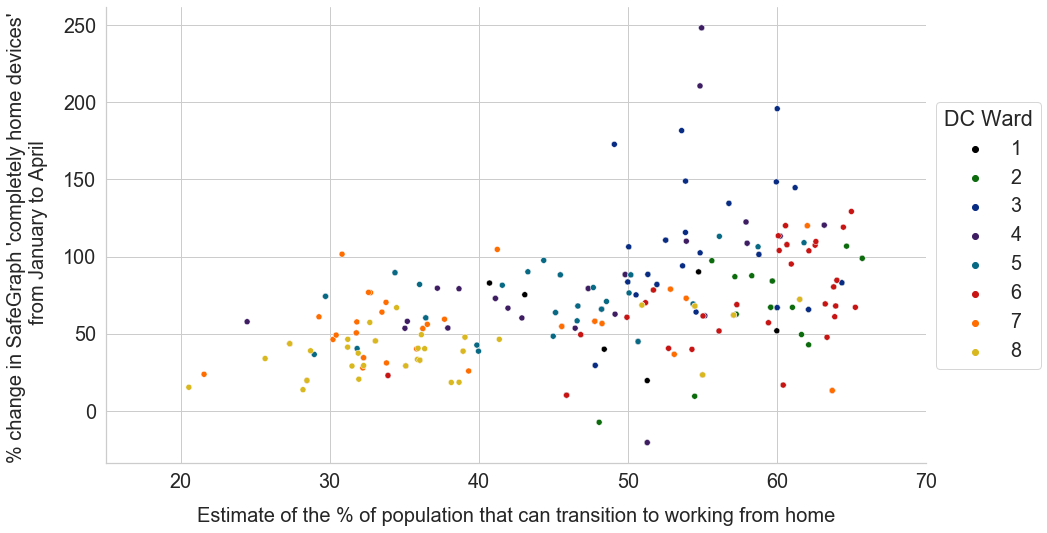

In [160]:
#***************************************************************
#Figure show how safegraph stay at home aligns with telework scores in April
#***************************************************************



title = "SafeGraph relationship to telework score"
fig, ax = plt.subplots(figsize=figure_size)
sns.set(font_scale=font_size_var)
sns.set_style("whitegrid")
sns.despine()
spring_data['Percent'] = spring_data['telework_score'] * 100
g = sns.scatterplot(data=spring_data, y="spring_pct_increase", x="Percent",
                hue="DC Ward",  legend = "full", palette = colorlist)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.legend_.set_title('DC Ward')


plt.xlabel("Estimate of the % of population that can transition to working from home",
          size = label_size, labelpad = axis_pad)
plt.ylabel("% change in SafeGraph 'completely home devices' \n from January to April",
          size = label_size, labelpad = axis_pad)
#plt.title(title)  
plt.xlim(15,70)
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    

In [140]:

corr, pval = pearsonr(spring_data["spring_pct_increase"], spring_data['Percent'])
print (corr, pval)

0.41967471597067996 4.5088843598318433e-13


In [ ]:
df_stayhome_all.head()

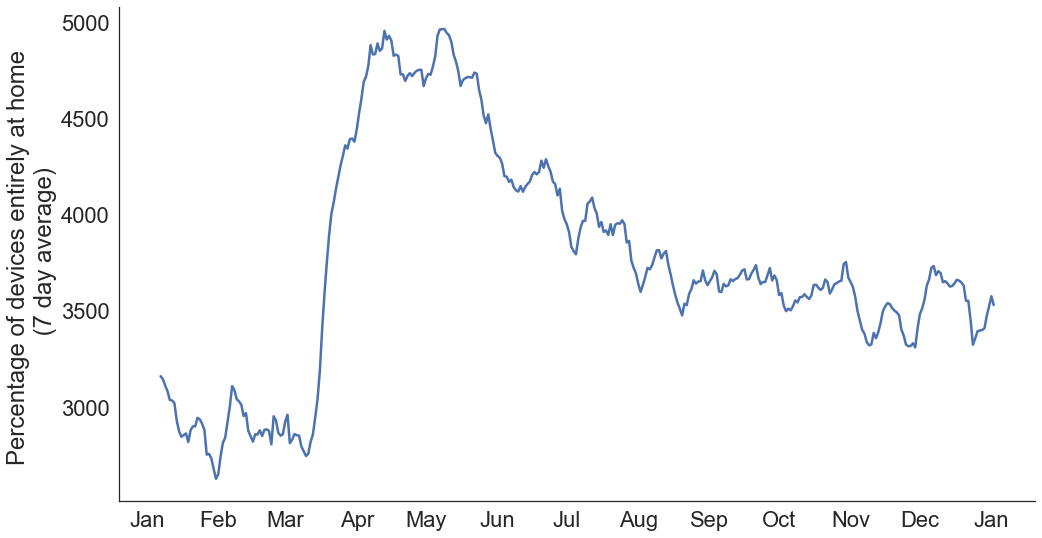

In [125]:
#*********************************************************************
#Figure: Percent of devices that stayed at home, for all of DC:
#*********************************************************************
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import calendar
import matplotlib.ticker as ticker


title = "SafeGraph mobility data for DC: Average percent of stay at home devices during COVID-19"
sns.set(font_scale=2,rc={"lines.linewidth": 2.5},)
sns.set_style("white")


fig, ax = plt.subplots(figsize=(15, 8))


sns.lineplot(x="Date", y="Percent of stay at home devices moving",
              palette = colorlist,
             data=daily_dc)
#plt.title(title)
plt.xlabel("")
plt.ylabel("Percentage of devices entirely at home \n (7 day average)")

#ax.tick_params(axis = 'x', which = 'major', length = 10)
#ax.tick_params(axis = 'x', which = 'minor', length = 5)


ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b"))

sns.despine()
plt.tight_layout()

#plt.xticks(rotation = 'vertical')
plt.savefig(title + ".png", dpi=500, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')




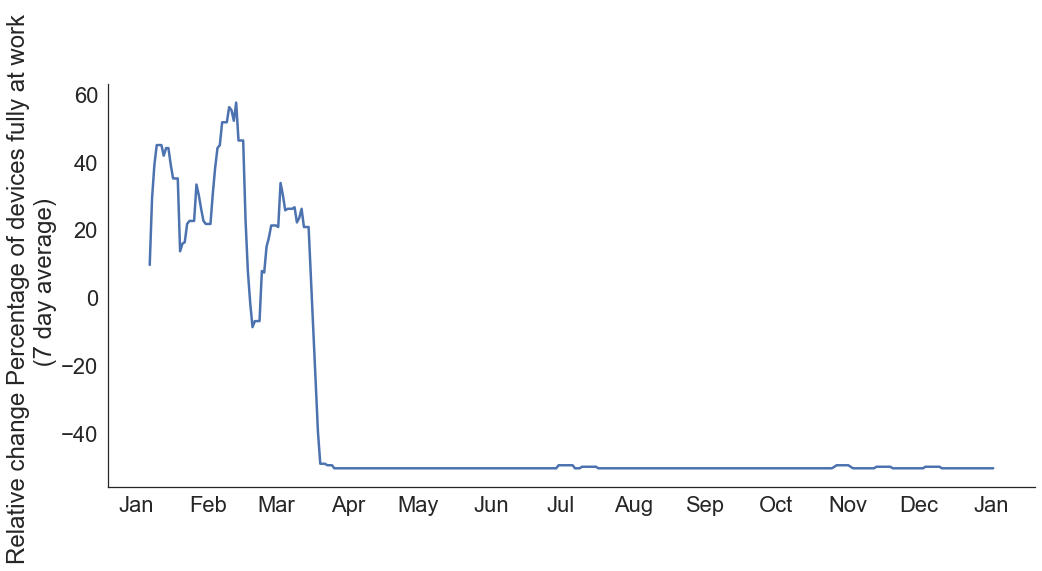

In [54]:
#*********************************************************************
#Figure: Percent of devices that stayed at home, for all of DC:
#*********************************************************************
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import calendar
import matplotlib.ticker as ticker


title = "SafeGraph mobility data for DC: Percent of full time work devices, percent change during COVID-19"
sns.set(font_scale=2,rc={"lines.linewidth": 2.5},)
sns.set_style("white")


fig, ax = plt.subplots(figsize=(15, 8))


sns.lineplot(x="Date", y='Full time work devices percent change moving',
              palette = parent_colors,
             data=daily_dc)
#plt.title(title)
plt.xlabel("")
plt.ylabel("Relative change Percentage of devices fully at work \n (7 day average)")

#ax.tick_params(axis = 'x', which = 'major', length = 10)
#ax.tick_params(axis = 'x', which = 'minor', length = 5)


ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b"))

sns.despine()
plt.tight_layout()

#plt.xticks(rotation = 'vertical')
#plt.savefig(title + ".png", dpi=500, facecolor='w', 
#            edgecolor='w', 
#            orientation='portrait')



In [55]:
#*********************************************************************
#Data Get weekly Safegraph data for all of DC
#*********************************************************************
agg_sf_week = {'completely_home_device_count':'median', 
          'device_count':'median', 
          'percent_home_device':'mean',
          'median_home_dwell_time':'median',
         'telework_score':'min',
              'stayhome_increase': 'mean',
             'stayhome_pct_increase':'mean'}



weekly_mobility_just_dc = weekly_mobility.groupby(['Week_Number']).agg(agg_sf_week).reset_index()

weekly_mobility_just_dc['Percent of stay at home devices'] = round(weekly_mobility_just_dc['percent_home_device']*100,1)
 
weekly_mobility_just_dc['LastDayWeek'] = (weekly_mobility_just_dc['Week_Number']-1).astype(str) + "6"
weekly_mobility_just_dc['Date'] = pd.to_datetime('2020'+ weekly_mobility_just_dc['LastDayWeek'], format="%Y%U%w")

weekly_mobility_just_dc.head()


NameError: name 'weekly_mobility' is not defined

In [ ]:
#*********************************************************************
#Data Get weekly Safegraph data
#*********************************************************************
agg_sf_week = {'completely_home_device_count':'median', 
          'device_count':'median', 
          'percent_home_device':'mean',
          'median_home_dwell_time':'median',
         'telework_score':'min',
              'stayhome_increase': 'mean',
             'stayhome_pct_increase':'mean'}


weekly_mobility = sf_df.merge(baseline_data, on = ['WARD', 'GEOID'])
weekly_mobility['stayhome_increase'] = weekly_mobility['percent_home_device'] -weekly_mobility['percent_home_baseline']
weekly_mobility['stayhome_pct_increase'] = weekly_mobility['stayhome_increase']/weekly_mobility['percent_home_baseline'] * 100

weekly_mobility_df = weekly_mobility.groupby(['WARD', 'Week_Number']).agg(agg_sf_week).reset_index()

weekly_mobility_df['Percent of stay at home devices'] = round(weekly_mobility_df['percent_home_device']*100,1)
 
weekly_mobility_df['LastDayWeek'] = (weekly_mobility_df['Week_Number']-1).astype(str) + "6"
weekly_mobility_df['Date'] = pd.to_datetime('2020'+ weekly_mobility_df['LastDayWeek'], format="%Y%U%w")
weekly_mobility_df.rename(columns = {'WARD': 'DC Ward'}, inplace = True)


weekly_mobility_df.head()

In [ ]:
#*********************************************************************
#Figure: Percent of devices that stayed at home, by ward:
#*********************************************************************
title = "Average percent of stay at home devices during COVID-19, by ward"
sns.set(font_scale=2,rc={"lines.linewidth": 2.5},)
sns.set_style("white")
#sns.despine(offset=10, trim=True);

fig, ax = plt.subplots(figsize=(15, 8))
ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b"))



sns.lineplot(x="Date", y="Percent of stay at home devices",
             hue='DC Ward', palette = parent_colors,
             data=weekly_mobility_df, legend = True)

plt.ylabel("Percentage of devices entirely at home \n (7 day average)")
#plt.title(title)
plt.xlabel("")
#plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.savefig(title + ".png", 
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



In [ ]:
#*********************************************************************
#Figure: % increase in devices that stayed at home, by ward:
#*********************************************************************
title = "Increase in % of people who stayed home, week over week compared to January-February"
sns.set(font_scale=2,rc={"lines.linewidth": 2.5},)
sns.set_style("white")
#sns.despine(offset=10, trim=True);

fig, ax = plt.subplots(figsize=(15, 8))


sns.lineplot(x="Date", y="stayhome_pct_increase",
             hue='DC Ward', palette = parent_colors,
             data=weekly_mobility_df)
#plt.title("Average percent increase in the number of \n devices that stayed home compared to January, by ward")
plt.ylabel("% increase in stay at home devices")
ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b"))


#plt.xticks(rotation=30)
sns.despine()
#plt.title(title)
plt.xlabel("")
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    



In [ ]:
#*********************************************************************
#Figure: spring data showing differences in wards
#*********************************************************************
title = ("Increase in people who stayed fully at home across DC wards in Spring, 2020")
agg_sf_spring = {'completely_home_device_count':'median', 
          'device_count':'median', 
          'percent_home_device':'mean',
          'median_home_dwell_time':'median',
         'telework_score':'min',
              'stayhome_increase': 'mean',
             'stayhome_pct_increase':'mean',
                'Percent of stay at home devices':'mean'}

weekly_mobility_df_spring = weekly_mobility_df[(weekly_mobility_df['Date']>'2020-04-01') &
                                              (weekly_mobility_df['Date']<'2020-05-29')]

spring_wards = weekly_mobility_df_spring.groupby(['DC Ward']).agg(agg_sf_spring).reset_index()
spring_wards['Percent increase from baseline'] = round(spring_wards['stayhome_pct_increase'],1)
spring_wards['name'] = np.where(spring_wards['DC Ward'] == 1, 'Ward 1',
                               np.where(spring_wards['DC Ward'] == 2, 'Ward 2',
                                       np.where(spring_wards['DC Ward']== 3, 'Ward 3',
                                               np.where(spring_wards['DC Ward'] == 4, 'Ward 4',
                                                       np.where(spring_wards['DC Ward']== 5, 'Ward 5',
                                                               np.where(spring_wards['DC Ward'] == 6, 'Ward 6',
                                                                       np.where(spring_wards['DC Ward'] == 7, 'Ward 7',
                                                                               np.where(spring_wards['DC Ward'] == 8, 'Ward 8', 'NULL'))))))))


fig, ax = plt.subplots(figsize=(15, 8))
sns.set(font_scale=2.2)
sns.set_style("whitegrid")
sns.despine()
sns.barplot(x="name", y="Percent increase from baseline",
            data=spring_wards, palette = parent_colors)


#plt.title(title)
plt.xlabel("")
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    


In [ ]:
#*********************************************************************
#Figure: spring data showing relative differences in wards
#*********************************************************************
fig, ax = plt.subplots(figsize=(15, 8))
sns.set(font_scale=2.2)
sns.set_style("whitegrid")
sns.despine()
sns.barplot(x="name", y='Percent of stay at home devices',
            data=spring_wards, palette = parent_colors)

title = "Percent of devices who stayed fully at home across DC wards in Spring, 2020"

# plt.title(title)
plt.xlabel("")
plt.tight_layout()
plt.savefig(title+".png",
            dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)    



In [ ]:
#cases, deaths and mobility across DC wards


agg_sf_day = {'completely_home_device_count':'sum', 
          'device_count':'sum', 
          'percent_home_device':'mean',
          'median_home_dwell_time':'median',
         'telework_score':'min',
              'stayhome_increase': 'mean',
             'stayhome_pct_increase':'mean'}

weekly_mobility_slim = weekly_mobility[['WARD', 'GEOID', 
                                        'origin_census_block_group', 'date_range_start',
       'date_range_end', 'device_count', 'distance_traveled_from_home',
       'completely_home_device_count', 'median_home_dwell_time','telework_score', 
       'percent_home_baseline', 'stayhome_increase', 'stayhome_pct_increase']]

daily_mobility_df = weekly_mobility.groupby(['WARD', 'date_range_start']).agg(agg_sf_day).reset_index()
daily_mobility_df['Date'] = pd.to_datetime(daily_mobility_df['date_range_start']).dt.date
#daily_mobility_df['Date_str'] = daily_mobility_df['date_range_start'].astype(str)
daily_mobility_df['place_fips'] = daily_mobility_df['WARD'].astype(int)


daily_mobility_df.tail()



In [ ]:
dc_case_data = dc_data[~dc_data['Ward'].isin(['Unknown', 'All DC'])].copy()
dc_case_data.drop(['Ward'],axis =1, inplace =True)
#dc_case_data['Date_str'] =  dc_case_data['Date'].astype(str)
dc_case_data['Date'] =  pd.to_datetime(dc_case_data['Date']).dt.date

dc_case_data['place_fips']=dc_case_data['place_fips'].astype(int)
dc_case_data.tail()

In [ ]:
cases_and_mobility= daily_mobility_df.merge(dc_case_data, on = ['place_fips','Date'], how = 'left')
cases_and_mobility.head()



In [ ]:
ward1 = cases_and_mobility[cases_and_mobility['place_fips'] == 1].copy()

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
#dc.rename(columns = {'new_Cases':'New daily cases'}, inplace = True)
#ward1.plot(x='Date', y= 'stayhome_pct_increase', kind='line', linewidth=3, 
#           color = parent_colors[0],   ax=ax1)
ward1.plot(x= 'Date', y= 'stayhome_pct_increase', kind='line', linewidth=3, 
           color = parent_colors[0],   ax=ax1)


ward1.plot(x= 'Date', y='moving_Cases', kind='line', color = '#d7dadb', ax=ax2)




In [ ]:
dc_case_data_ward1 = cases_and_mobility[cases_and_mobility['place_fips']==1]
sns.barplot(x="Date", y='moving_Cases',
            data=dc_case_data_ward1)



In [ ]:
cases_and_mobility.head()